<a href="https://colab.research.google.com/github/SD19167/hw3/blob/main/%E3%80%8Ccolab_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Watermarking

## Installation

In [ ]:
#@title Install requirements
!pip install torchaudio
!pip install matplotlib
!pip install audioseal
!pip install ffmpeg-python

In [ ]:
import io
import ffmpeg
import IPython.display as ipd
from google.colab.output import eval_js

from base64 import b64decode
from scipy.io.wavfile import read as wav_read
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchaudio

from audioseal import AudioSeal

In [ ]:
#波形圖&頻譜圖
def plot_waveform_and_specgram(waveform, sample_rate, title):
    waveform = waveform.squeeze().detach().cpu().numpy()

    num_frames = waveform.shape[-1]
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(time_axis, waveform, linewidth=1)
    ax1.grid(True)
    ax2.specgram(waveform, Fs=sample_rate)

    figure.suptitle(f"{title} - Waveform and specgram")
    plt.show()


def play_audio(waveform, sample_rate):
    if waveform.dim() > 2:
        waveform = waveform.squeeze(0)
    waveform = waveform.detach().cpu().numpy()

    num_channels, *_ = waveform.shape
    if num_channels == 1:
        ipd.display(ipd.Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        ipd.display(ipd.Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [ ]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(ipd.HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

## Record your audio

In [ ]:
recorded, sr = get_audio()

# Convert audio from list of int16 to a normalized tensor
audio = torch.tensor(recorded).float() / 32768.0
# print(audio.shape)

## Generator

In [ ]:
model = AudioSeal.load_generator("audioseal_wm_16bits")

audios = audio.unsqueeze(0).unsqueeze(0)  # b=1 c=1 t

watermark = model.get_watermark(audios, sample_rate=sr)
watermarked_audio = audios + watermark


# alpha越大浮水印越明顯
watermarked_audio = model(audios, sample_rate=sr, alpha=1)

# secret message
# secret_mesage = torch.randint(0, 2, (1, 16), dtype=torch.int32)
# watermarked_audio = model(audios, sample_rate=sr, message=secret_mesage, alpha=1)

Downloading: "https://huggingface.co/facebook/audioseal/resolve/main/generator_base.pth" to /root/.cache/audioseal/0f195d476dd87ca1bd7b09e6
100%|██████████| 56.1M/56.1M [00:00<00:00, 65.1MB/s]


## waveform and specgram

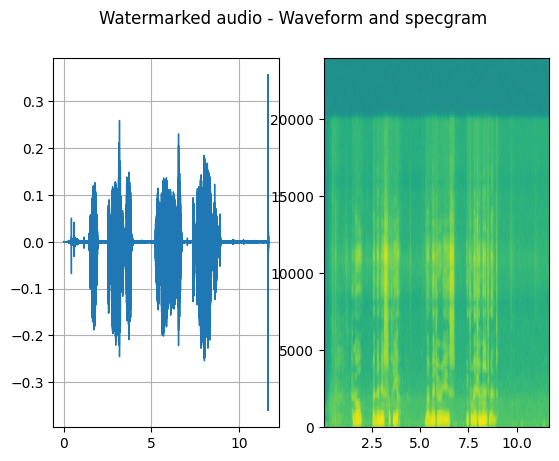

In [ ]:
plot_waveform_and_specgram(watermarked_audio.squeeze(), sr, title="Watermarked audio")

In [ ]:
play_audio(watermarked_audio, sr)

## Detector


In [ ]:
detector = AudioSeal.load_detector(("audioseal_detector_16bits"))

result, message = detector.detect_watermark(watermarked_audio, sample_rate=sr, message_threshold=0.5)

print(f"\nThis is likely a watermarked audio. WM probability: {result}")

# unwatermarked audio
result2, message2 = detector.detect_watermark(audios, sample_rate=sr, message_threshold=0.5)
print(f"This is likely an unwatermarked audio. WM probability: {result2}")


Downloading: "https://huggingface.co/facebook/audioseal/resolve/main/detector_base.pth" to /root/.cache/audioseal/94c8df0b1d5ea8e45af4c884
100%|██████████| 33.1M/33.1M [00:00<00:00, 54.0MB/s]



This is likely a watermarked audio. WM probability: 1.0
This is likely an unwatermarked audio. WM probability: 0.000381540710804984


In [ ]:
message

tensor([[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1]], dtype=torch.int32)

## Advance Detector

In [ ]:
pred_prob, message_prob = detector(watermarked_audio, sample_rate=sr)
pred_prob[:, 1, :]

tensor([[0.9973, 0.9973, 0.9974,  ..., 0.9993, 0.9993, 0.9992]],
       grad_fn=<SliceBackward0>)

In [ ]:
message_prob

tensor([[0.7561, 0.2457, 0.2397, 0.7959, 0.1893, 0.7931, 0.1892, 0.2399, 0.2666,
         0.2394, 0.7490, 0.2729, 0.7922, 0.7310, 0.8198, 0.2548]],
       grad_fn=<SigmoidBackward0>)

### Robustness against attacks

We can evaluate the robustness of the detector against some attacks. For this purpose, we will perform some simple attacks: Pink noise, highpass filter, compression in different formats. For the full list of attacks, please refer to our paper.


#### Pink noise attack

In [ ]:
from attacks import AudioEffects as af

pink_noised_audio = af.pink_noise(watermarked_audio, noise_std=0.1)
plot_waveform_and_specgram(pink_noised_audio, sample_rate=sr, title="Audio with pink noise")
result, message = detector.detect_watermark(pink_noised_audio, sample_rate=sr)
print(result)

#### Lowpass filter

In [ ]:
lowpass_filtered = af.lowpass_filter(watermarked_audio, cutoff_freq=5000, sample_rate=sr)
plot_waveform_and_specgram(lowpass_filtered, sample_rate=sr, title="Audio with low pass filtered")
result, message = detector.detect_watermark(lowpass_filtered, sample_rate=sr)
print(result)